# Autoencoder para classificação
Com autoencoder também conseguimos fazer classificação, que nesse caso é conhecido como detecção de anomalia. A vantagem de se utilizar o autoencoder para essa tarefa é que podemos treinar com dados de uma única amostra, util em situações em que nosso sistema majoritariamente gera um unico tipo de amostra, por exemplo: peças boas em uma linha de produção. Tudo que diferir do padrão aprendido pelo autoencoder será considerado uma anomalia, dessa forma com o autoencoder teremos um modelo de classificação binária: Imagens dentro do padrão e imagens anomalas.

Vantagens:
* Por se tratar de autoencoder temos a caracteristica de treinamento não supervisionado o que implica que não precisamos classificar nossos dados, apenas coletar as amostras dentro do padrão esperado.
* Além de detectar imagens anomalas, com autoencoder podemos rastrear na imagem a região da imagem que gerou a anomalia

Desvantagens:
* Performance inferior em relação ao treinamento supervisionado
* Apenas funciona para classificação binária
* Modelos mais complexos com maior tempo de inferencia (Encoder + Decoder)
* Se usarmos autoencoder para classificação binária porque não temos amostras de outra classe, como validar e confiar o modelo para produção?

In [1]:
import cv2
import numpy as np
from imutils import paths
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from matplotlib import pyplot as plt
from tqdm import tqdm

## BatchGenerator
Para esse exemplo iremos utilizar um dataset que foi gerado durante a fase de desenvolvimento do MVP. Com o uso do BatchGenerator não iremos precisar carregar todas as imagens na memória e realizar nosso pre processamento em tempo de execução.

In [2]:
class BatchGenerator(Sequence):
    def __init__(self, path, batch_size, image_size=(28, 28), gray_scale=True):
        self._batch_size = batch_size
        self._images_path = list(paths.list_images(path))[:300]  # para fins de exemplo vamos utilziar apenas 300 imagens
        self._image_size = image_size
        self._gray_scale = gray_scale

    def __len__(self):
        return int(np.ceil(len(self._images_path) / self._batch_size))

    def __getitem__(self, idx):
        l_bound = idx * self._batch_size
        r_bound = (idx + 1) * self._batch_size

        if r_bound > len(self._images_path):
            r_bound = len(self._images_path)
            l_bound = r_bound - self._batch_size

        instance_count = 0
        x_batch = np.zeros((r_bound - l_bound, self._image_size[1], self._image_size[0], 1 if self._gray_scale else 3))

        for instance_count, train_instance in enumerate(self._images_path[l_bound:r_bound]):
            image = cv2.imread(train_instance)
            image = cv2.resize(image, self._image_size)
            if self._gray_scale:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = image[..., np.newaxis]
            image = image / 255
            x_batch[instance_count] = image

        return x_batch, x_batch

    def on_epoch_end(self):
        np.random.shuffle(self._images_path)

#### Instanciar os generator
generator para treino e validação

In [3]:
train_generator = BatchGenerator("./data/screw_dataset/train/wo_screw", 8)
val_generator = BatchGenerator("./data/screw_dataset/train/wo_screw", 8)

## Criação do autoencoder

In [4]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # output (4, 4, 8)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

#### Callback para salvar os modelos com o melhor loss

In [5]:
MODEL_NAME = "anomaly_detector"
best_loss_model_name = f"{MODEL_NAME}_best_loss.h5"
check_point_saver_best_loss = ModelCheckpoint(best_loss_model_name, monitor='val_loss', verbose=1,
                                              save_best_only=True, save_weights_only=False, mode='auto',
                                              period=1)

###### Treino

In [6]:
autoencoder.fit(train_generator, validation_data=val_generator, epochs=200, callbacks=[check_point_saver_best_loss])

Epoch 1/200
36/38 [===========================>..] - ETA: 0s - loss: 0.6524
Epoch 1: val_loss improved from inf to 0.63353, saving model to anomaly_detector_best_loss.h5
38/38 [==============================] - 3s 42ms/step - loss: 0.6551 - val_loss: 0.6335
Epoch 2/200
36/38 [===========================>..] - ETA: 0s - loss: 0.6243
Epoch 2: val_loss improved from 0.63353 to 0.61258, saving model to anomaly_detector_best_loss.h5
38/38 [==============================] - 1s 37ms/step - loss: 0.6239 - val_loss: 0.6126
Epoch 3/200
37/38 [============================>.] - ETA: 0s - loss: 0.6068
Epoch 3: val_loss improved from 0.61258 to 0.59815, saving model to anomaly_detector_best_loss.h5
38/38 [==============================] - 1s 34ms/step - loss: 0.6060 - val_loss: 0.5982
Epoch 4/200
38/38 [==============================] - ETA: 0s - loss: 0.5931
Epoch 4: val_loss improved from 0.59815 to 0.58996, saving model to anomaly_detector_best_loss.h5
38/38 [==============================] - 1s 

# Validação

In [7]:
autoencoder = load_model(best_loss_model_name)

1/1 [==============================] - 0s 156ms/step


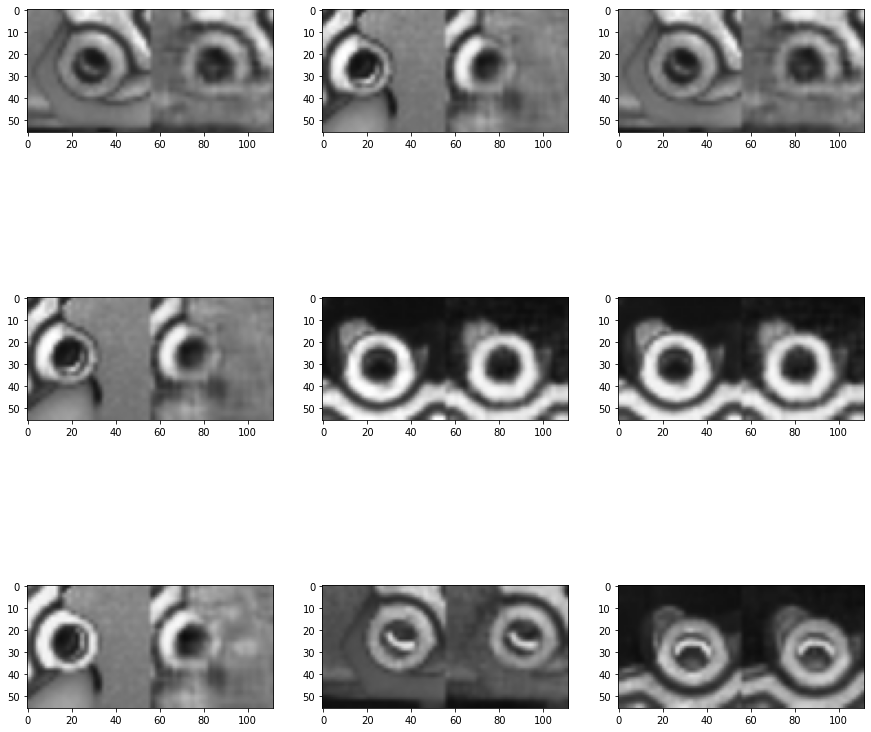

In [8]:
plt.figure(figsize=(15,15))
test_generator = BatchGenerator("./data/screw_dataset/val/wo_screw", 9)

# batch = next(test_generator)
batch = next(iter(test_generator))[0]

preds = autoencoder.predict(batch)
for i, (gt, pred) in enumerate(zip(batch, preds)):
    plt.subplot(3,3,i+1)
    
    gt = np.uint8(gt * 255)
    pred = np.uint8(pred * 255)
    concat = cv2.hconcat([gt, pred])
    concat = cv2.resize(concat, None, fx=2, fy=2)
    plt.imshow(cv2.cvtColor(concat, cv2.COLOR_GRAY2RGB))
plt.show()

## Exercicio
Observe a geração de imagens pelo autoencoder em imagens que estão fora do padrão (imagens com parafusos), como ficou as imagens geradas?

Compare as imagens de entrada vs de saída e crie uma métrica para classificar as anomalias

In [9]:
def calc_mse(generator):
    mse = []
    for sample, _ in tqdm(generator):
        pred = autoencoder.predict(sample)

        se = pred - sample
        se = se ** 2
        se = se.sum()
        mse.append(se)
    mse = np.asarray(mse)
    return mse.mean(), mse.std()

true_generator = BatchGenerator("./data/screw_dataset/val/wo_screw", 1)
anomaly_generator = BatchGenerator("./data/screw_dataset/val/torx", 1)
print(calc_mse(true_generator))
print(calc_mse(anomaly_generator))

  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 2/300 [00:00<00:16, 17.59it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 5/300 [00:00<00:15, 19.26it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 8/300 [00:00<00:14, 19.81it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 10/300 [00:00<00:14, 19.55it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 12/300 [00:00<00:16, 17.83it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 14/300 [00:00<00:15, 18.33it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 17/300 [00:00<00:14, 18.96it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 19/300 [00:01<00:15, 18.47it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 22/300 [00:01<00:14, 18.76it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 25/300 [00:01<00:14, 19.32it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 28/300 [00:01<00:13, 19.51it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 31/300 [00:01<00:13, 19.85it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 33/300 [00:01<00:13, 19.27it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 35/300 [00:01<00:13, 18.95it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 38/300 [00:01<00:13, 19.21it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 41/300 [00:02<00:13, 19.42it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 43/300 [00:02<00:13, 19.52it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 45/300 [00:02<00:13, 19.36it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 48/300 [00:02<00:12, 19.40it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 50/300 [00:02<00:12, 19.46it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 52/300 [00:02<00:12, 19.41it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 54/300 [00:02<00:12, 19.12it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 56/300 [00:02<00:12, 18.96it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 58/300 [00:03<00:13, 18.37it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 61/300 [00:03<00:12, 19.10it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 63/300 [00:03<00:12, 18.50it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 65/300 [00:03<00:12, 18.42it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 67/300 [00:03<00:12, 18.59it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 70/300 [00:03<00:11, 19.30it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 72/300 [00:03<00:11, 19.45it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 74/300 [00:03<00:11, 19.44it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 76/300 [00:03<00:11, 19.22it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 78/300 [00:04<00:11, 19.22it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 81/300 [00:04<00:11, 19.56it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 83/300 [00:04<00:11, 19.51it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 85/300 [00:04<00:10, 19.62it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 87/300 [00:04<00:11, 19.05it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 90/300 [00:04<00:10, 19.66it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 93/300 [00:04<00:10, 19.84it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 96/300 [00:04<00:10, 19.85it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 98/300 [00:05<00:10, 19.54it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 101/300 [00:05<00:10, 19.75it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 104/300 [00:05<00:09, 19.99it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 106/300 [00:05<00:09, 19.86it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 108/300 [00:05<00:09, 19.84it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 110/300 [00:05<00:09, 19.09it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 112/300 [00:05<00:09, 18.89it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 114/300 [00:05<00:09, 19.10it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 116/300 [00:06<00:09, 19.16it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 118/300 [00:06<00:09, 19.33it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 120/300 [00:06<00:09, 18.89it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 122/300 [00:06<00:09, 18.74it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 125/300 [00:06<00:09, 18.90it/s]

1/1 [==============================] - 0s 63ms/step


 42%|████▏     | 127/300 [00:06<00:10, 17.24it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 129/300 [00:06<00:09, 17.55it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 131/300 [00:06<00:09, 17.96it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 133/300 [00:06<00:09, 18.42it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 135/300 [00:07<00:08, 18.72it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 138/300 [00:07<00:08, 19.26it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 140/300 [00:07<00:08, 18.74it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 142/300 [00:07<00:08, 19.03it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 144/300 [00:07<00:08, 19.10it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 147/300 [00:07<00:07, 19.51it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 149/300 [00:07<00:07, 19.25it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 151/300 [00:07<00:07, 18.81it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 154/300 [00:08<00:07, 19.20it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 157/300 [00:08<00:07, 19.66it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 159/300 [00:08<00:07, 19.65it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 161/300 [00:08<00:07, 19.36it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 163/300 [00:08<00:07, 19.09it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 165/300 [00:08<00:07, 19.14it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 168/300 [00:08<00:06, 19.49it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 170/300 [00:08<00:06, 19.58it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 173/300 [00:09<00:06, 18.93it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 175/300 [00:09<00:06, 19.16it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 178/300 [00:09<00:06, 19.47it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 181/300 [00:09<00:05, 19.85it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 183/300 [00:09<00:06, 19.34it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 185/300 [00:09<00:05, 19.37it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 187/300 [00:09<00:05, 19.50it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 189/300 [00:09<00:05, 19.18it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 192/300 [00:10<00:05, 19.60it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 194/300 [00:10<00:05, 19.58it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 196/300 [00:10<00:05, 19.29it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 199/300 [00:10<00:05, 19.66it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 201/300 [00:10<00:05, 19.69it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 204/300 [00:10<00:04, 19.87it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 206/300 [00:10<00:04, 19.54it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 208/300 [00:10<00:04, 19.17it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 210/300 [00:10<00:04, 19.38it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 212/300 [00:11<00:04, 19.21it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 215/300 [00:11<00:04, 19.79it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 217/300 [00:11<00:04, 19.35it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 220/300 [00:11<00:04, 19.69it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 222/300 [00:11<00:03, 19.58it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 225/300 [00:11<00:03, 19.74it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 228/300 [00:11<00:03, 19.62it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 230/300 [00:11<00:03, 19.64it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 232/300 [00:12<00:03, 19.49it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 234/300 [00:12<00:03, 19.53it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 236/300 [00:12<00:03, 19.62it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 238/300 [00:12<00:03, 16.91it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 240/300 [00:12<00:03, 17.64it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 242/300 [00:12<00:03, 18.00it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 245/300 [00:12<00:02, 18.66it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 248/300 [00:12<00:02, 19.13it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 250/300 [00:13<00:02, 18.18it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 252/300 [00:13<00:02, 18.36it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 255/300 [00:13<00:02, 19.21it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 257/300 [00:13<00:02, 18.74it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 259/300 [00:13<00:02, 18.14it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 261/300 [00:13<00:02, 17.02it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 263/300 [00:13<00:02, 16.69it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 265/300 [00:13<00:02, 16.86it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 267/300 [00:14<00:01, 17.19it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 269/300 [00:14<00:01, 16.75it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 271/300 [00:14<00:01, 16.66it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 273/300 [00:14<00:01, 16.80it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 275/300 [00:14<00:01, 16.90it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 277/300 [00:14<00:01, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 279/300 [00:14<00:01, 16.64it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 281/300 [00:14<00:01, 16.66it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 283/300 [00:14<00:00, 17.01it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 285/300 [00:15<00:00, 17.36it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 287/300 [00:15<00:00, 16.36it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 289/300 [00:15<00:00, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 291/300 [00:15<00:00, 16.03it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 293/300 [00:15<00:00, 16.27it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 295/300 [00:15<00:00, 16.48it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 297/300 [00:15<00:00, 16.51it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 299/300 [00:15<00:00, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 300/300 [00:16<00:00, 18.70it/s]


(2.7541323591955633, 1.1064806629764796)


  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 2/300 [00:00<00:16, 18.07it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 4/300 [00:00<00:16, 18.16it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 6/300 [00:00<00:16, 17.33it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 8/300 [00:00<00:16, 17.68it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 10/300 [00:00<00:16, 17.81it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 12/300 [00:00<00:15, 18.12it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 14/300 [00:00<00:15, 18.65it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 16/300 [00:00<00:15, 18.14it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 18/300 [00:00<00:15, 18.38it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 21/300 [00:01<00:14, 18.96it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 23/300 [00:01<00:14, 18.90it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 26/300 [00:01<00:14, 19.31it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 28/300 [00:01<00:14, 18.92it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 30/300 [00:01<00:14, 19.07it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 32/300 [00:01<00:14, 19.03it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 35/300 [00:01<00:13, 19.49it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 37/300 [00:01<00:13, 19.24it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 39/300 [00:02<00:19, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 41/300 [00:02<00:17, 14.81it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 43/300 [00:02<00:16, 15.72it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 45/300 [00:02<00:15, 16.49it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 47/300 [00:02<00:17, 14.30it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 49/300 [00:02<00:16, 14.84it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 51/300 [00:02<00:15, 15.86it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 53/300 [00:03<00:14, 16.58it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 55/300 [00:03<00:14, 17.17it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 57/300 [00:03<00:13, 17.75it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 59/300 [00:03<00:13, 18.13it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 61/300 [00:03<00:12, 18.46it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 63/300 [00:03<00:12, 18.86it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 65/300 [00:03<00:12, 18.77it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 67/300 [00:03<00:12, 18.77it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 69/300 [00:03<00:12, 18.82it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 71/300 [00:04<00:12, 18.90it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 74/300 [00:04<00:11, 19.38it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 76/300 [00:04<00:12, 18.46it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 78/300 [00:04<00:11, 18.74it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 81/300 [00:04<00:11, 19.26it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 84/300 [00:04<00:11, 19.60it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 86/300 [00:04<00:11, 19.19it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 88/300 [00:04<00:11, 19.22it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 90/300 [00:05<00:11, 18.99it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 92/300 [00:05<00:10, 18.97it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 95/300 [00:05<00:10, 19.41it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 97/300 [00:05<00:10, 19.03it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 100/300 [00:05<00:10, 19.21it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 102/300 [00:05<00:10, 19.28it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 105/300 [00:05<00:09, 19.63it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 107/300 [00:05<00:10, 18.94it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 109/300 [00:06<00:10, 19.08it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 111/300 [00:06<00:10, 18.32it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 114/300 [00:06<00:09, 18.94it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 116/300 [00:06<00:09, 18.66it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 118/300 [00:06<00:09, 18.59it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 121/300 [00:06<00:09, 19.36it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 123/300 [00:06<00:09, 19.34it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 125/300 [00:06<00:09, 18.88it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 128/300 [00:07<00:08, 19.20it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 131/300 [00:07<00:08, 19.52it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 133/300 [00:07<00:08, 19.50it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 135/300 [00:07<00:08, 19.34it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 137/300 [00:07<00:08, 19.23it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 139/300 [00:07<00:08, 19.09it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 142/300 [00:07<00:08, 19.43it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 144/300 [00:07<00:08, 19.15it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 146/300 [00:07<00:08, 19.18it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 149/300 [00:08<00:07, 19.63it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 151/300 [00:08<00:07, 19.49it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 154/300 [00:08<00:07, 19.55it/s]

1/1 [==============================] - 0s 73ms/step


 52%|█████▏    | 156/300 [00:08<00:08, 17.42it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 158/300 [00:08<00:08, 17.07it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 160/300 [00:08<00:08, 17.46it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 163/300 [00:08<00:07, 18.51it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 165/300 [00:08<00:07, 18.66it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 167/300 [00:09<00:07, 18.70it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 169/300 [00:09<00:07, 18.62it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 171/300 [00:09<00:07, 18.10it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 173/300 [00:09<00:06, 18.43it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 176/300 [00:09<00:06, 19.14it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 179/300 [00:09<00:06, 19.46it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 181/300 [00:09<00:06, 19.30it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 183/300 [00:09<00:06, 19.34it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 185/300 [00:10<00:06, 18.75it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 187/300 [00:10<00:06, 18.70it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 190/300 [00:10<00:05, 19.25it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 192/300 [00:10<00:05, 19.09it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 194/300 [00:10<00:05, 19.04it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 197/300 [00:10<00:05, 19.39it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 199/300 [00:10<00:05, 19.51it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 202/300 [00:10<00:05, 19.33it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 204/300 [00:11<00:04, 19.36it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 206/300 [00:11<00:04, 19.40it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 208/300 [00:11<00:04, 18.93it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 211/300 [00:11<00:04, 19.47it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 213/300 [00:11<00:04, 19.26it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 215/300 [00:11<00:04, 19.16it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 218/300 [00:11<00:04, 19.51it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 221/300 [00:11<00:04, 19.72it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 223/300 [00:11<00:03, 19.62it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 225/300 [00:12<00:03, 19.27it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 228/300 [00:12<00:03, 19.59it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 231/300 [00:12<00:03, 19.52it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 234/300 [00:12<00:03, 19.71it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 236/300 [00:12<00:03, 19.37it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 239/300 [00:12<00:03, 19.81it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 241/300 [00:12<00:03, 19.62it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 244/300 [00:13<00:02, 19.78it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 247/300 [00:13<00:02, 19.49it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 250/300 [00:13<00:02, 19.78it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 252/300 [00:13<00:02, 19.08it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 255/300 [00:13<00:02, 19.39it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 257/300 [00:13<00:02, 18.63it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 259/300 [00:13<00:02, 18.89it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 261/300 [00:13<00:02, 17.25it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 264/300 [00:14<00:01, 18.15it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 267/300 [00:14<00:01, 18.80it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 269/300 [00:14<00:01, 18.72it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 271/300 [00:14<00:01, 18.87it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 273/300 [00:14<00:01, 19.16it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 275/300 [00:14<00:01, 19.37it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 278/300 [00:14<00:01, 19.68it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 280/300 [00:14<00:01, 19.24it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 282/300 [00:15<00:00, 18.81it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 284/300 [00:15<00:00, 17.25it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 286/300 [00:15<00:00, 16.89it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 288/300 [00:15<00:00, 16.24it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 290/300 [00:15<00:00, 16.18it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 292/300 [00:15<00:00, 15.88it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 294/300 [00:15<00:00, 15.89it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 296/300 [00:15<00:00, 16.12it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 298/300 [00:16<00:00, 15.69it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 300/300 [00:16<00:00, 18.48it/s]

(19.030276425666763, 3.8949194681253814)


1/1 [==============================] - 0s 30ms/step


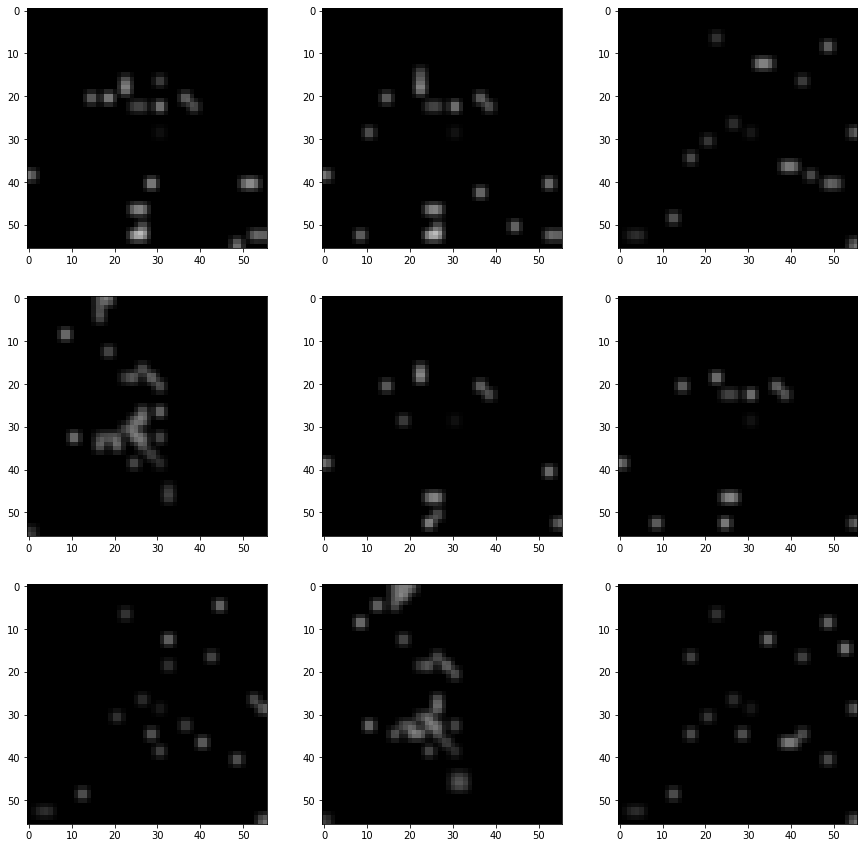

In [10]:
plt.figure(figsize=(15,15))
test_generator = BatchGenerator("./data/screw_dataset/train/wo_screw", 9)

# batch = next(test_generator)
batch = next(iter(test_generator))[0]

preds = autoencoder.predict(batch)
for i, (gt, pred) in enumerate(zip(batch, preds)):
    plt.subplot(3,3,i+1)
    
    gt = gt[..., 0]
    pred = pred[..., 0]
    error = abs(gt - pred)
    error = error > 0.17
    error = np.uint8(error * 255)
    
    pred = np.uint8(pred * 255)
    pred = cv2.bitwise_and(pred, error)
    pred = cv2.resize(pred, None, fx=2, fy=2)
    plt.imshow(cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB))
plt.show()